# Time Series Basics

## Background
Up until now we've dealt with data whose samples (i.e. rows of `X`) did not depend on each other. Such data is often referred to as IID, i.e. independent and identically distributed. This means that the samples are independent (they don't depend on each other), and they are all generated from the same underlying probability distribution. With IID data, shuffling the samples or randomly subsampling from them doesn't change the underlying distribution. This is why we could create training and test sets by just randomly sampling some data for training and some data for testing.

Now we'll spend some time talking about how to deal with situations where time dependencies do occur in the data. These types of data are called _time series_. Time series differ from IID data in that there is a natural order in the data, usually time. The order of samples in the dataset does matter. In a time series dataset it's typical for a sample to depend on data taken at previous times (so samples are not independent), and for data taken at different times to have different underlying distributions (so samples are not identically distributed). Samples are only allowed to depend on previous times (and not future times) because time series are _causal_, meaning the future can't be allowed to affect the past.

In math speak, the difference between IID data and time series data is as follows. Note if this looks like gibberish to you just ignore it. You can get along fine with the above intuitive definition.
- If the input dataset $X=\{ x_1,x_2,\cdots,x_n\}$ is IID, then each sample $x_i$ has the same distribution $p(x)$, and independence means $p(x_i,x_j)=p(x_i)p(x_j)$ when $i\neq j$. 
- If the input dataset $X=\{ x_1,x_2,\cdots,x_T\}$ is a time series with time indexes $t=1,\cdots,T$, then $X$ forms a discrete-time [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) where each $x_t$ is distributed with some t-dependent distribution $p_t(x)$. Moreover, $X$ is causal, meaning $x_t$ is completely independent of future values, i.e. $p(x_t,x_s)=p_t(x_t)p_s(x_s)$ when $s\geq t$, but $x_t$ is only conditionally independent given previous values $x_1,\cdots,x_{t-1}$, i.e. 
$$p(x_t,x_{t-1},\cdots,x_2,x_1)=p(x_t|x_{t-1},\cdots,x_1,x_2)p(x_{t-1},\cdots,x_2,x_1).$$

Side remark: One can also imagine continuous-time processes as well. This leads to the far more sophisticated topics of continuous-time stochastic processes and [stochastic differential equations](https://en.wikipedia.org/wiki/Stochastic_differential_equation). Since in practices we only ever have a finite amount of data though, we can always assume for our purposes that time is discrete.

## Getting Started
In this notebook, we'll very briefly talk about visualizing, filtering, decomposing, and forecasting simple (univariate) time series. Many of these techniques form the building block for more advanced time series ML techniques. Note if you've never worked with time series before this may feel like getting sprayed with a fire hose. Just go through it as many times as you need to to get an idea what the big picture is.

We've already worked with the `pandas` library a little bit before. Now we'll actually get to see some of the cool functionality that pandas has for working with time series data. We'll also be working with a new library, `statsmodels`, that contains many time series analysis tools. We'll also work with the less well known library `stldecompose` for doing STL decompositions (which statsmodels doesn't yet support sadly). The only functions we'll predefine are functions for importing the data. By default we'll be working with the `get_data` function, which loads in a "live" dataset, but feel free to play around on your own with the `custom_data` function, which allows you to create your own time series.

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import naive, drift, mean, seasonal_naive

np.random.seed(23)

In [148]:
def custom_data(trange,period):
    t = np.linspace(0,trange,1000)
    f = lambda t: (0.0003*t+.08*np.sin(2*np.pi/period*t))*len(t)
    x = f(t) + .03*len(t)*np.random.normal(0,1,len(t))
    df = pd.DataFrame({'t':t,'x':x})
    df = df.set_index('t')
    return df

def get_data():
    df = sm.datasets.co2.load_pandas().data
    df.index = pd.to_datetime(df.index)
    df = df.resample('D').mean().interpolate('linear')
    return df

As usual, we'll begin by loading in our data. The data we'll use is the [Mauna Loa Weekly Atmospheric CO2 Dataset](https://www.statsmodels.org/dev/datasets/generated/co2.html), which contains about 50 years of atmospheric CO2 concentration measurements. The `get_data` function loads in this dataset and does some light processing on the raw data before return a pandas dataframe whose index is time and only feature is `co2`, the CO2 emissions values.

Observe that the index of the dataframe contains the datetime when each measurement was collected. Pandas has a special datetime format that allows users to encode time data in a user-friendly way. Using this format allows you to do things like resample the data by second, minute, hour, day, week, month, or year, which is often very useful when working with time series. By keeping the time information in the dataframe index, pandas automatically keeps things in time-sorted order for you, so doing this is always recommended.

In our particular case, the data was collected once a day, so each entry is a single day. This is called the sampling frequency of the time series, and it's very important to know what this frequency is when working with the data. For instance, since we know the sampling frequency is daily here, and that atmospheric measurements vary by time of year, we can infur that the period of the data, i.e. the time it takes for the series to complete one periodic oscillation, is 365 (since a year is 365 days). Keeping track of the period (or sampling frequency) will be essential for what we do below.

In [149]:
df = get_data()
period = 365
df.head()

,co2
1958-03-29,316.100000
1958-03-30,316.271429
1958-03-31,316.442857
1958-04-01,316.614286
1958-04-02,316.785714


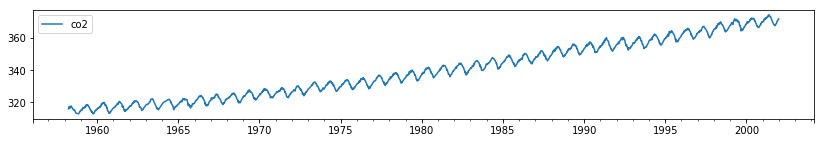

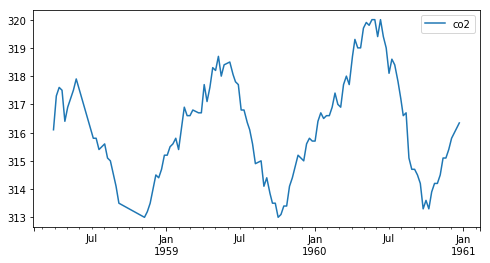

In [150]:
df.plot(figsize=(14,2))
df.head(1000).plot(figsize=(8,4))

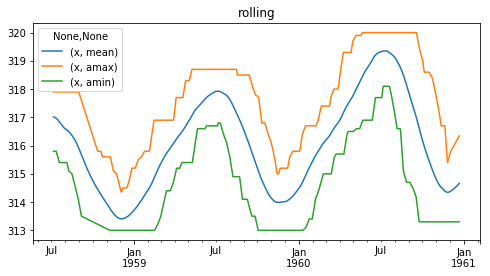

In [97]:
df.rolling(100).aggregate([np.mean,np.max,np.min]).head(1000).plot(title='rolling',figsize=(8,4))

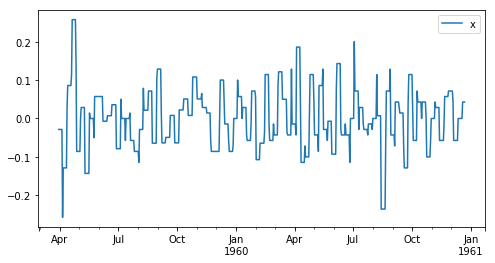

In [98]:
df.diff().diff(periods=period).head(1000).plot(figsize=(8,4))

## Autocorrelations

blah blah

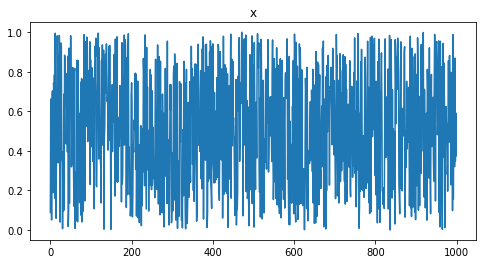

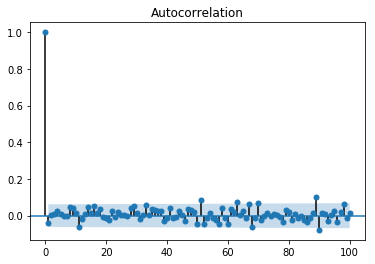

In [104]:
x = np.random.rand(1000)
fig = plt.figure(figsize=(8,4))
plt.plot(x)
plt.title('x')
fig = plot_acf(x, lags=100)
plt.show()

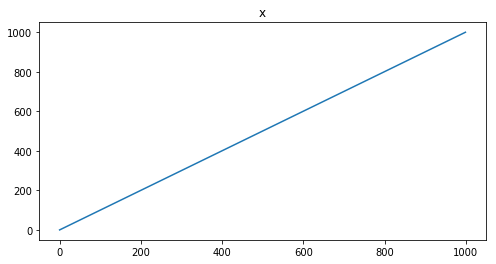

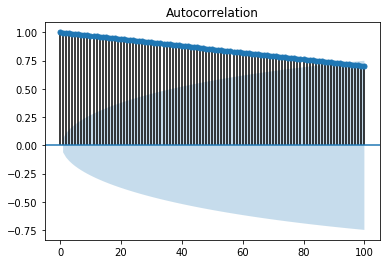

In [105]:
x = np.linspace(0,1000,1000)
fig = plt.figure(figsize=(8,4))
plt.plot(x)
plt.title('x')
fig = plot_acf(x, lags=100)
plt.show()

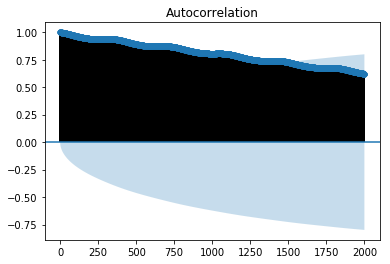

In [29]:
fig = plot_acf(df, lags=2000)
plt.show()

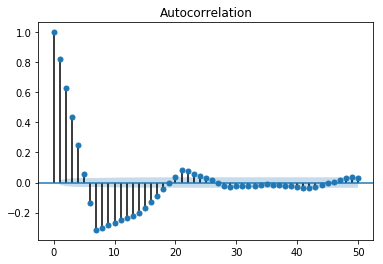

In [42]:
diffs = df.diff(periods=period).diff()
fig = plot_acf(diffs.dropna(), lags=50)
plt.show()

## Time Series Decompositions

blah blah

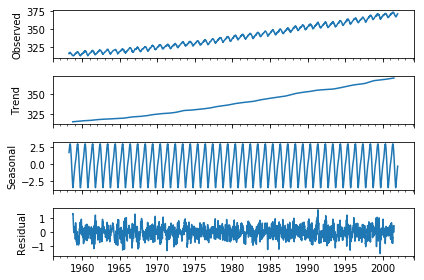

In [126]:
decomp = seasonal_decompose(df,freq=period)
fig = decomp.plot()
plt.show()

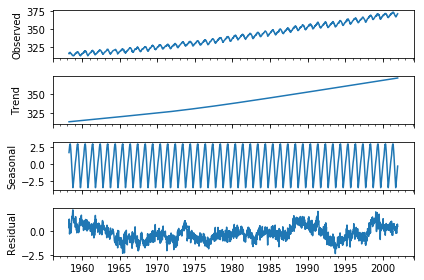

In [130]:
stl = decompose(df.x, period=period)
stl.plot()
plt.show()

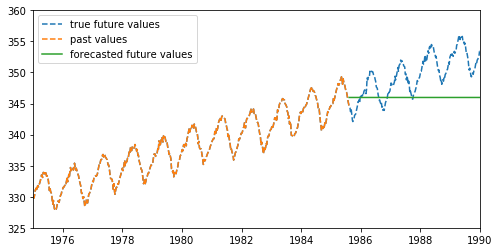

In [190]:
past_vals = df.head(10000)
past_stl = decompose(short_obs, period=365)
fcast = forecast(past_stl, steps=8000, fc_func=mean, seasonal=False) # fc_func=mean,drift,naive,seasonal_naive

fig = plt.figure(figsize=(8,4))
plt.plot(df, '--', label='true future values')
plt.plot(past_vals, '--', label='past values')
plt.plot(fcast, '-', label='forecasted future values')
plt.xlim('1975','1990')
plt.ylim(325,360)
plt.legend()
plt.show()

Number of detected anomalies:  8


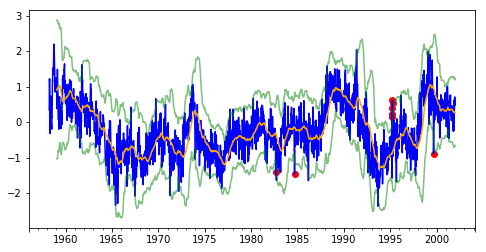

In [189]:
resids = stl.resid
window = 300
mu = resids.rolling(window).mean()
sigma = resids.rolling(window).std()
is_anom = (resids-mu).abs() > 4*sigma
anomalies = resids[is_anom]
print('Number of detected anomalies: ',len(anomalies))

fig = plt.figure(figsize=(8,4))
resids.plot(color='blue')
(mu-3*sigma).plot(color='green', linestyle='-', alpha=0.5)
(mu+3*sigma).plot(color='green', linestyle='-', alpha=0.5)
mu.plot(color='orange', linestyle='-')
plt.scatter(anomalies.index,anomalies,color='red')
plt.show()